In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-12 14:51:01,570: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import sys
!{sys.executable} -m pip install mitiq

In [4]:
# Importing mitiq and curve fitting
import mitiq
from mitiq import zne

from scipy.optimize import curve_fit

In [5]:
# Loading our image in the Quantum State
test_image = Image.open('clock_test_image_8x8.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)
np_test_image = np_test_image.reshape((8,8))
print("Original Image Pixel values: ")
print(np_test_image)


Original Image Pixel values: 
[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


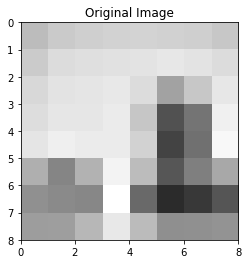

Normalized Image Pixel values: 
[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


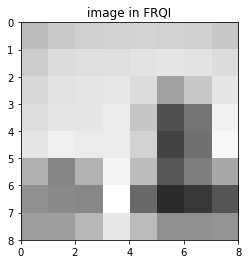

In [6]:
# Function to plot our image
def plot_image8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image8x8(np_test_image, "Original Image")   

# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array
    
def plot_image8x8_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(8):
        for y in range(8):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (8**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print("Normalized Image Pixel values: ")
print(np_test_image_normalized)

plot_image8x8_denormalized(np_test_image_normalized, np_test_image, np_test_image_normalized, 'image in FRQI')

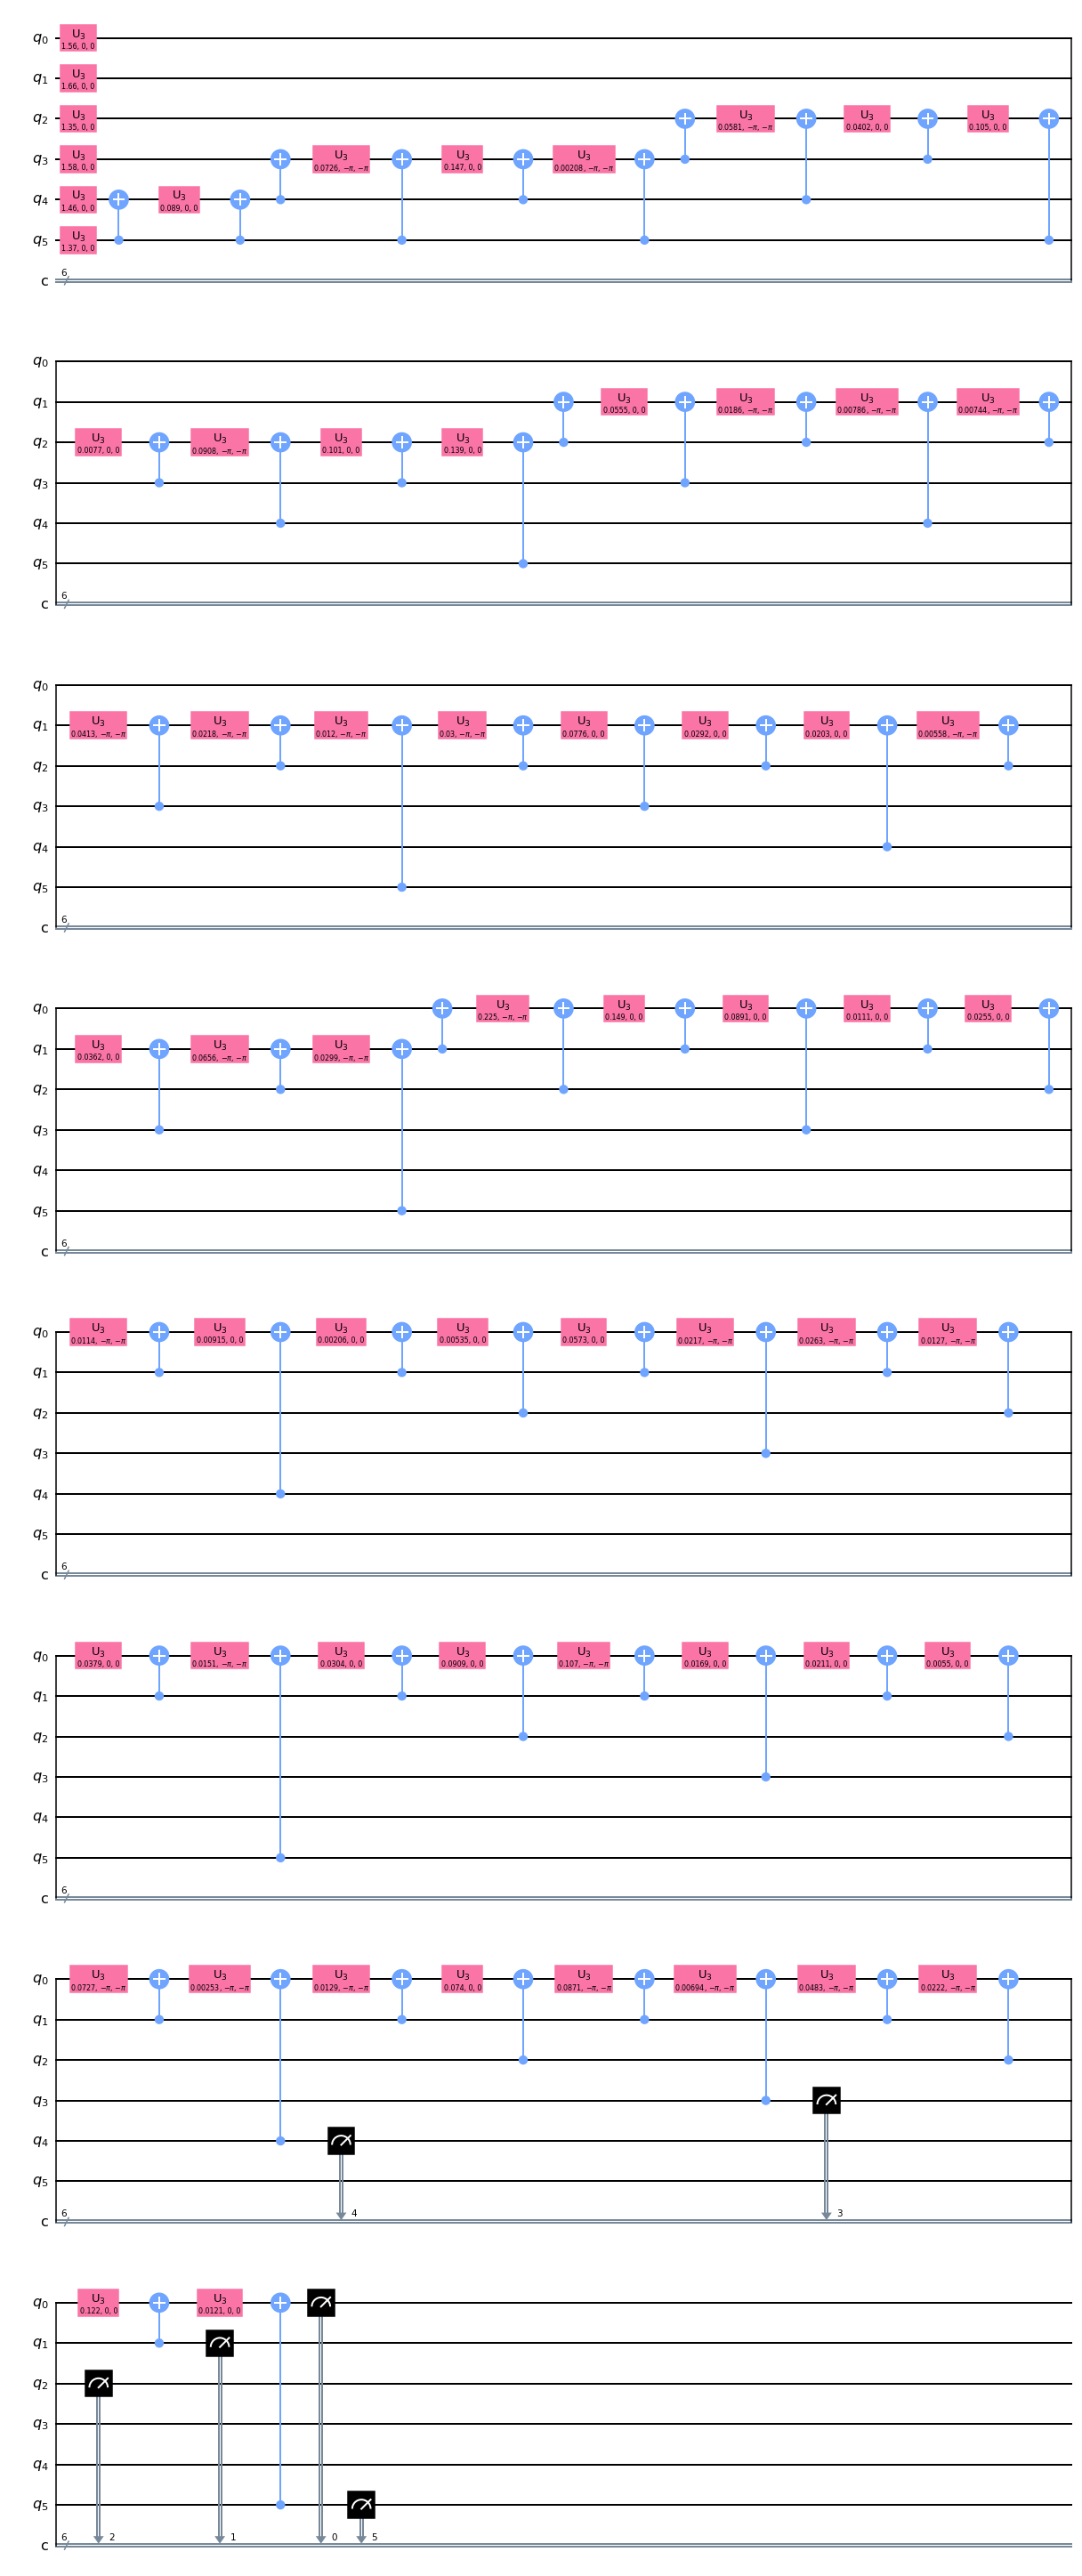

In [7]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(6,6)

qc_image.initialize(np_test_image_normalized.reshape(8**2))

qc_image.measure(range(6), range(6))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image.draw()

Aer Simulator Output Image Pixel Values: 
[[0.2770379  0.29197603 0.29874738 0.28504386]
 [0.29453353 0.30248967 0.06123724 0.31104662]
 [0.09082951 0.31424513 0.16881943 0.31064449]
 [0.14491377 0.30618622 0.14230249 0.14747881]]


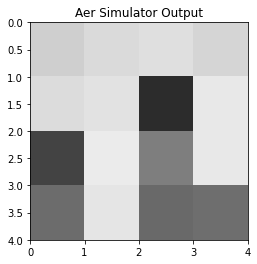

In [21]:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
print("Aer Simulator Output Image Pixel Values: ")
print(np_simulator_output)

plot_image4x4_denormalized(np_simulator_output, np_test_image, np_test_image_normalized, 'Aer Simulator Output')

In [8]:
# Calculating Error:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [9]:
# Routines to plot errors and extrapolations associated with each pixel
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, (int(scale_factors[-1]) + 1)])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, len(scale_factors), 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()

In [11]:
# EDIT THIS CELL TO RUN AN EXPERIMENT!

# scale_factors is an array of noise multipliers
scale_factors = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

# Number of shots to run
shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=1,  
   shots=shots
)

# Note the backend and Job_ID used!

ibmqfactory.load_account:WARNING:2022-10-12 14:52:44,133: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [12]:
# Copy the backend and Job_ID in this cell:
# Backend: ibmq_kolkata Job_ID: 6346d4c80a4a0c02bfd02215
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('6346d4c80a4a0c02bfd02215')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-12 14:56:25,592: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

IBMQ_Kolkata Output Image Pixels:
[[0.25059928 0.24149534 0.19697716 0.17935997 0.2034699  0.21491859
  0.17549929 0.16890826]
 [0.17796067 0.19949937 0.14869432 0.13501852 0.1545639  0.1497331
  0.13061393 0.12739702]
 [0.155692   0.16081045 0.14456832 0.13809417 0.13652839 0.13228757
  0.12296341 0.11623253]
 [0.1422322  0.15172343 0.11171392 0.11644741 0.12778889 0.11545562
  0.08596511 0.10540398]
 [0.09751923 0.12206556 0.11445523 0.09027735 0.11588788 0.08348653
  0.07681146 0.09060905]
 [0.09648834 0.09038805 0.06123724 0.07674634 0.0801249  0.07375636
  0.06196773 0.06534524]
 [0.0746994  0.08408329 0.07348469 0.08024961 0.06892024 0.06774954
  0.05549775 0.05504544]
 [0.06826419 0.07829432 0.05822371 0.06236986 0.05347897 0.0669328
  0.04857983 0.04816638]]


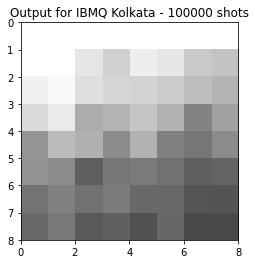

IBMQ_Kolkata (w/ ZNE) Output Image Pixels:
[[0.23929182 0.26222073 0.20854462 0.20890296 0.18711081 0.20969143
  0.17232453 0.16477636]
 [0.18437059 0.18708277 0.14643973 0.15484001 0.13571652 0.15074643
  0.12142242 0.13380032]
 [0.14773774 0.13993958 0.12003017 0.12441255 0.11461153 0.11177503
  0.09169858 0.09663281]
 [0.10990462 0.12051552 0.08696713 0.09841918 0.09376924 0.08975424
  0.06698042 0.08101266]
 [0.12784444 0.15987126 0.1365688  0.13502582 0.1209638  0.10747412
  0.09091982 0.11237214]
 [0.11022732 0.113007   0.08409692 0.10439562 0.08981569 0.08326992
  0.07507348 0.08155243]
 [0.08538011 0.08197987 0.07629494 0.07619898 0.06784499 0.06519065
  0.0537891  0.05548985]
 [0.06580254 0.07178647 0.05797385 0.06139956 0.05368979 0.05697239
  0.04585032 0.04670059]]


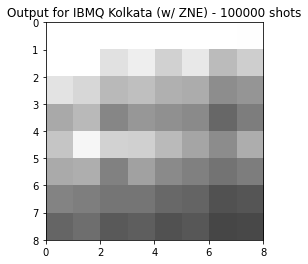

In [14]:
# Plotting the outputs:
print("IBMQ_Kolkata Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata - 100000 shots')

print("IBMQ_Kolkata (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata (w/ ZNE) - 100000 shots')

In [22]:
# RUN THIS CELL!!!!
# ibmq_kolkata is under maintenance, we're going to try using ibmq_mumbai,
# backend: ibmq_mumbai,  Job_ID: 633ea91583172d68f5d199aa
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_mumbai")
kolkata_job = backend_kolkata.retrieve_job('633ea91583172d68f5d199aa')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-06 10:20:53,910: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

IBMQ Kolkata Output Image Pixels:
[[0.25059928 0.24149534 0.19697716 0.17935997 0.2034699  0.21491859
  0.17549929 0.16890826]
 [0.17796067 0.19949937 0.14869432 0.13501852 0.1545639  0.1497331
  0.13061393 0.12739702]
 [0.155692   0.16081045 0.14456832 0.13809417 0.13652839 0.13228757
  0.12296341 0.11623253]
 [0.1422322  0.15172343 0.11171392 0.11644741 0.12778889 0.11545562
  0.08596511 0.10540398]
 [0.09751923 0.12206556 0.11445523 0.09027735 0.11588788 0.08348653
  0.07681146 0.09060905]
 [0.09648834 0.09038805 0.06123724 0.07674634 0.0801249  0.07375636
  0.06196773 0.06534524]
 [0.0746994  0.08408329 0.07348469 0.08024961 0.06892024 0.06774954
  0.05549775 0.05504544]
 [0.06826419 0.07829432 0.05822371 0.06236986 0.05347897 0.0669328
  0.04857983 0.04816638]]


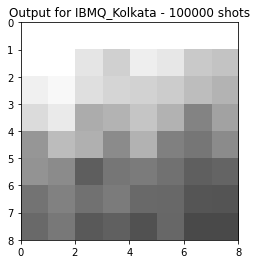

IBMQ Kolkata (w/ ZNE) Output Image Pixels:
[[0.23929182 0.26222073 0.20854462 0.20890296 0.18711081 0.20969143
  0.17232453 0.16477636]
 [0.18437059 0.18708277 0.14643973 0.15484001 0.13571652 0.15074643
  0.12142242 0.13380032]
 [0.14773774 0.13993958 0.12003017 0.12441255 0.11461153 0.11177503
  0.09169858 0.09663281]
 [0.10990462 0.12051552 0.08696713 0.09841918 0.09376924 0.08975424
  0.06698042 0.08101266]
 [0.12784444 0.15987126 0.1365688  0.13502582 0.1209638  0.10747412
  0.09091982 0.11237214]
 [0.11022732 0.113007   0.08409692 0.10439562 0.08981569 0.08326992
  0.07507348 0.08155243]
 [0.08538011 0.08197987 0.07629494 0.07619898 0.06784499 0.06519065
  0.0537891  0.05548985]
 [0.06580254 0.07178647 0.05797385 0.06139956 0.05368979 0.05697239
  0.04585032 0.04670059]]


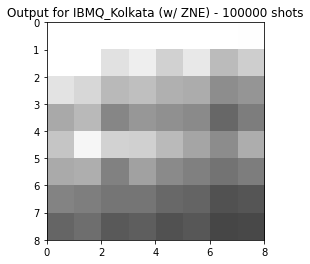

In [15]:
# Plotting the outputs:
print("IBMQ Kolkata Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ_Kolkata - 100000 shots')

print("IBMQ Kolkata (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for IBMQ_Kolkata (w/ ZNE) - 100000 shots')

In [16]:
# Calculating and Displaying the RMSE errors:
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8), 8) 
rmse_kolkata_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8), 8) 
print("Simulator error (100000 shots): ", (rmse_kolkata * 100), "% per pixel")
print("Simulator (with ZNE) error (100000 shots): ", (rmse_kolkata_zne * 100), "% per pixel")

Simulator error (100000 shots):  3.3838317783007064 % per pixel
Simulator (with ZNE) error (100000 shots):  3.4129962489725796 % per pixel


In [28]:
# EDIT THIS CELL TO RUN AN EXPERIMENT!

# scale_factors is an array of noise multipliers
scale_factors = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

# Number of shots to run
shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = Aer.get_backend("aer_simulator")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

# Note the backend and Job_ID used!

ibmqfactory.load_account:WARNING:2022-10-06 10:30:10,998: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  aer_simulator


In [29]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

Aer Simulator Output Image Pixels:
[[0.25059928 0.24149534 0.19697716 0.17935997 0.2034699  0.21491859
  0.17549929 0.16890826]
 [0.17796067 0.19949937 0.14869432 0.13501852 0.1545639  0.1497331
  0.13061393 0.12739702]
 [0.155692   0.16081045 0.14456832 0.13809417 0.13652839 0.13228757
  0.12296341 0.11623253]
 [0.1422322  0.15172343 0.11171392 0.11644741 0.12778889 0.11545562
  0.08596511 0.10540398]
 [0.09751923 0.12206556 0.11445523 0.09027735 0.11588788 0.08348653
  0.07681146 0.09060905]
 [0.09648834 0.09038805 0.06123724 0.07674634 0.0801249  0.07375636
  0.06196773 0.06534524]
 [0.0746994  0.08408329 0.07348469 0.08024961 0.06892024 0.06774954
  0.05549775 0.05504544]
 [0.06826419 0.07829432 0.05822371 0.06236986 0.05347897 0.0669328
  0.04857983 0.04816638]]


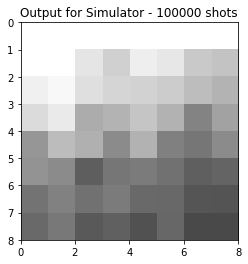

Aer Simulator (w/ ZNE) Output Image Pixels:
[[0.23929182 0.26222073 0.20854462 0.20890296 0.18711081 0.20969143
  0.17232453 0.16477636]
 [0.18437059 0.18708277 0.14643973 0.15484001 0.13571652 0.15074643
  0.12142242 0.13380032]
 [0.14773774 0.13993958 0.12003017 0.12441255 0.11461153 0.11177503
  0.09169858 0.09663281]
 [0.10990462 0.12051552 0.08696713 0.09841918 0.09376924 0.08975424
  0.06698042 0.08101266]
 [0.12784444 0.15987126 0.1365688  0.13502582 0.1209638  0.10747412
  0.09091982 0.11237214]
 [0.11022732 0.113007   0.08409692 0.10439562 0.08981569 0.08326992
  0.07507348 0.08155243]
 [0.08538011 0.08197987 0.07629494 0.07619898 0.06784499 0.06519065
  0.0537891  0.05548985]
 [0.06580254 0.07178647 0.05797385 0.06139956 0.05368979 0.05697239
  0.04585032 0.04670059]]


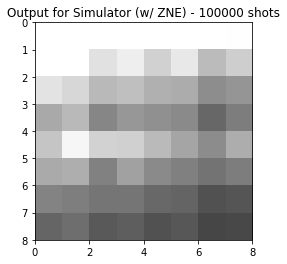

In [17]:
# Plotting the outputs:
print("Aer Simulator Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for Simulator - 100000 shots')

print("Aer Simulator (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for Simulator (w/ ZNE) - 100000 shots')

In [20]:
# Calculating and Displaying the RMSE errors:
rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8), 8) 
rmse_simulator_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8), 8) 
print("Simulator error (100000 shots): ", (rmse_simulator * 100), "% per pixel")
print("Simulator (with ZNE) error (100000 shots): ", (rmse_simulator_zne * 100), "% per pixel")

Simulator error (100000 shots):  0.1290513871473497 % per pixel
Simulator (with ZNE) error (100000 shots):  0.08338960082774646 % per pixel


In [18]:
from skimage.metrics import structural_similarity as ssim
np_kolkata_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8)
np_kolkata_zne_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8)

ssim_kolkata = ssim(np_test_image, np_kolkata_output_unnormalized, data_range=np_kolkata_output_unnormalized.max() - np_kolkata_output_unnormalized.min())
ssim_kolkata_zne = ssim(np_test_image, np_kolkata_zne_output_unnormalized, data_range=np_kolkata_zne_output_unnormalized.max() - np_kolkata_zne_output_unnormalized.min())
print("IBMQ_Kolkata SSIM: ", (ssim_kolkata * 100), "% Similar")
print("IBM Kolkata (w/ ZNE) SSIM: ", (ssim_kolkata_zne * 100), "% Similar")

IBMQ_Kolkata SSIM:  52.39742563736005 % Similar
IBM Kolkata (w/ ZNE) SSIM:  51.48906095735059 % Similar


In [ ]:
from skimage.metrics import structural_similarity as ssim
np_simulator_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8)
np_simulator_zne_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8)

ssim_simulator = ssim(np_test_image, np_simulator_output_unnormalized, data_range=np_simulator_output_unnormalized.max() - np_simulator_output_unnormalized.min())
ssim_simulator_zne = ssim(np_test_image, np_simulator_zne_output_unnormalized, data_range=np_simulator_zne_output_unnormalized.max() - np_simulator_zne_output_unnormalized.min())
print("Simulator SSIM: ", (ssim_simulator * 100), "% Similar")
print("Simulator (w/ ZNE) SSIM: ", (ssim_simulator_zne * 100), "% Similar")

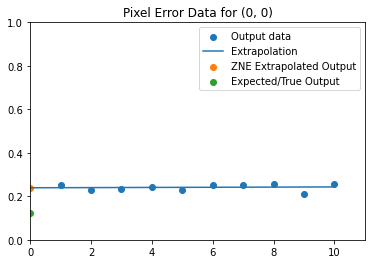

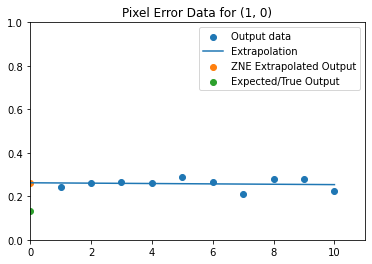

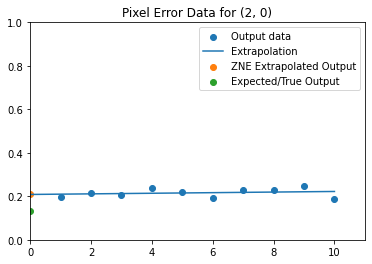

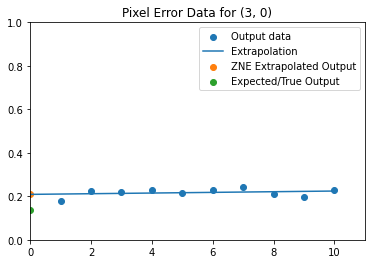

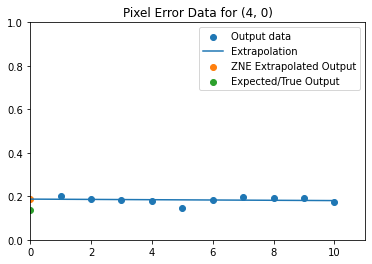

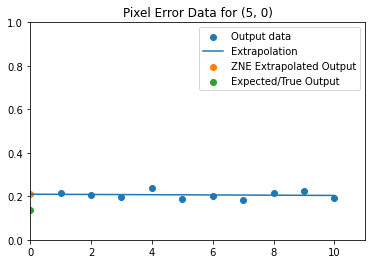

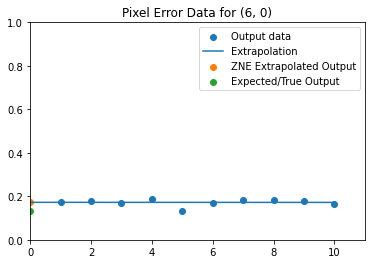

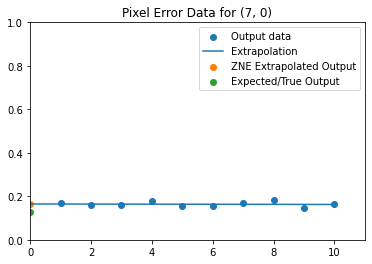

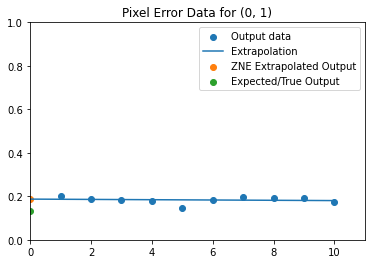

In [ ]:
# Plotting all of the errors and extrapolations for each pixel
for y in range(8):
    for x in range(8):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)